In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import linear_kernel
from copy import deepcopy
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

Read the file

In [3]:
file = pd.read_excel('shortcourses2566.xlsx')

Create Series of users

In [4]:
s_name = file.loc[:, 'ชื่อ-นามสกุล (อังกฤษ)']
Users = pd.Series(s_name, name='Users')
Users

0             PORPHAING JANTIP
1         THANAKORN DARASRISAK
2             KARNJANA EAMTANG
3             KARNJANA EAMTANG
4       THITIMUN VORATHONGCHAI
                 ...          
6122         KITTINON SANTASUP
6123      WITTAWAT SERMSRIPONG
6124               NON NAKKARA
6125         PHATTHARAPHON LIN
6126      THANAPAT SEEMAKAJOHN
Name: Users, Length: 6127, dtype: object

Create Series of emails

In [5]:
s_email = file.loc[:, 'อีเมล'].fillna("")
Emails = pd.Series(s_email ,name='Emails')
Emails


0            tanghaoren17@gamil.com
1               tuakung21@gmail.com
2            karnjana.aon@gmail.com
3            karnjana.aon@gmail.com
4          thitimun.rama1@gmail.com
                   ...             
6122           kittinon_s@cmu.ac.th
6123        wittawat_serm@cmu.ac.th
6124          non_nakkara@cmu.ac.th
6125    phattharaphon_lin@cmu.ac.th
6126         thanapat_see@cmu.ac.th
Name: Emails, Length: 6127, dtype: object

Provide a score to each user based on their email domain

In [6]:
email_score = []
for data in Emails:
    if data != '':
        if data.split('@')[1] == 'cmu.ac.th':
            email_score.append(2)
        else:
            email_score.append(1)
    else:
        email_score.append(0)
email_score = pd.Series(email_score, name='Score Emails')
email_score

0       1
1       1
2       1
3       1
4       1
       ..
6122    2
6123    2
6124    2
6125    2
6126    2
Name: Score Emails, Length: 6127, dtype: int64

Create function to calculate age-education score

In [7]:
def getAgeEducationScore(age, limit_age):
    if age <= limit_age:
        score = 1
    else:
        score = 3
    return score

Create Series of Age-Education

In [8]:
ages = file.loc[:, 'อายุ']
educations = file.loc[:, 'วุฒิการศึกษา']
age_education_scores = []
# check output length of age_education_scores until it has 6127
for i,x in enumerate(educations):
    if  x == 'อื่นๆ (-)' or pd.isna(x) :
        age_education_scores.append(getAgeEducationScore(ages[i], 0))
    elif x == 'ประถมศึกษา' or x == 'อื่นๆ (ป.4)' or x == 'อื่นๆ (ป.7)' or x == 'อื่นๆ (ป7)':
        age_education_scores.append(getAgeEducationScore(ages[i], 16))
    elif x == 'มัธยมศึกษาตอนต้น' or x == 'Secondary school' or x == 'อื่นๆ (มศ.3)':
        age_education_scores.append(getAgeEducationScore(ages[i], 19))
    elif x == 'มัธยมศึกษาตอนปลาย' or x == 'High school' or x == 'Vocational' or x == 'การศึกษานอกระบบ' \
            or x == 'ประกาศนียบัตรวิชาชีพ (ปวช.)' or x == 'อื่นๆ (ม.ปลาย จบหลักสูตรEMR เป็นจนท.ปฏิบัติการ)' \
            or x == 'อื่นๆ (กำลังศึกษาชั้นมัธยมศึกษาตอนปลาย)' or x == 'อื่นๆ (กำลังศึกษาชั้นมัธยมศึกษาปีที่6)' \
            or x == 'อื่นๆ (มศ.5)' :
        age_education_scores.append(getAgeEducationScore(ages[i], 22))
    elif x == 'ปริญญาตรี' or x == 'Bachelor degree' or x == 'Diploma' or x == 'High Vocational' \
            or x == 'ประกาศนียบัตรวิชาชีพชั้นสูง (ปวส.)' or x == 'อื่นๆ (กำลังศึกษาในระดับปริญญาตรี)' \
            or x == 'อื่นๆ (กำลังศึกษาปริญญาตรี สาขารังสีเทคนิค)' or x == 'อื่นๆ (ปริญญาแพทยศาสตร์บัณฑิต)' \
            or x == 'อื่นๆ (นักศึกษาแพทย์ปี 5)' or x == 'อื่นๆ (นักศึกษาแพทย์ มช ปี4 ศูนย์เชียงราย)' \
            or x == 'อื่นๆ (แพทยศาสตร์บัณฑิต)' or x == 'อื่นๆ (แพทย์)'  or x == 'อื่นๆ (ประกาศณียบัตรผู้ช่วยพยาบาล)' \
            or x == 'อนุปริญญา' or x == 'อื่นๆ (ป.ตรี)' or x == 'อื่นๆ (ผู้ช่วยพยาบาล)':
        age_education_scores.append(getAgeEducationScore(ages[i], 26))
    elif x == 'ปริญญาโท' or x == 'ปริญญาเอก' or x == "Master's degree" or x == 'Other (OBGYN specalist lavel 1)' \
            or x == 'Other (Residency)' or x == 'Ph.D.' or x == 'อื่นๆ (Internal Medicine)' \
            or x == 'อื่นๆ (เฉพาะทาง)' or x == ('อื่นๆ (วุฒิบัตร)') or x == 'อื่นๆ (วว.ออร์โธปิดิกส์)' \
            or x == 'อื่นๆ (วุฒิบัตรแสดงความรู้ความชำนาญในการประกอบวิชาชีพเภสัชกรรม สาขาเภสัชบำบัด)' \
            or x == 'อื่นๆ (วุฒิบัตรผู้เชี่ยวชาญสาขาทันตกรรมทั่วไป)' or x == 'อื่นๆ (วุฒิบัตรศัลยศาสตร์และแม็กซิลโลเฟเชียล)':
        age_education_scores.append(getAgeEducationScore(ages[i], 40))
print(len(age_education_scores))

6127


Create Series of status

In [9]:
status = file.loc[:, 'สถานะ'].fillna("")
status = pd.Series(status ,name='status')

Provide a score to each user based on their purchase status

In [10]:
status_score = []
for x in status:
    if x == 'ชำระเงิน':
        status_score.append(8)
    if x == 'ไม่ผ่านการอนุมัติ':
        status_score.append(7)
    if x == 'ค้างชำระ':
        status_score.append(5)

Create Series of address

In [11]:
address = file.loc[:, 'ที่อยู่'].fillna("")
address = pd.Series(address ,name='status')

Provide a score to each user based on their providing address information or not

In [18]:
address_score = []
for x in address:
    if x == "":
        address_score.append(3)
    else:
        address_score.append(4)

Convert list to pandas series

In [13]:
email_score = pd.Series(email_score)
# age_education_scores = pd.Series(age_education_scores)
status_score = pd.Series(status_score, name='Payment Score')
address_score = pd.Series(address_score, name='Address Score')

Create DataFrame by merging these 4 Series and calculate impressive level

In [14]:
d = {
    'Email Score': email_score,
    # 'Age Education Score': age_education_scores,
    'Payment Score': status_score,
    'Address Score': address_score,
    'Point': email_score + status_score + address_score,
    'Impressive Level': ( email_score + status_score + address_score ) / 16
}
df = pd.DataFrame(d)
df

,Email Score,Payment Score,Address Score,Point,Impressive Level
0,1,8,3,12,0.7500
1,1,8,4,13,0.8125
2,1,8,3,12,0.7500
3,1,8,3,12,0.7500
4,1,8,3,12,0.7500
...,...,...,...,...,...
6122,2,8,3,13,0.8125
6123,2,8,3,13,0.8125
6124,2,8,3,13,0.8125
6125,2,8,3,13,0.8125


Create user-course table

In [15]:
user = file.loc[:, 'ชื่อ-นามสกุล (อังกฤษ)']
course = file.loc[:, 'หลักสูตรอบรมระยะสั้น']
score = df['Impressive Level']
data = {
    'user': user,
    'course': course,
    'score': score,
}

predata = pd.DataFrame(data)
predata = predata.pivot_table(index='course', columns='user', values='score').fillna(0)
predata

user,AAIYANA MUSTAFA,ABDULFATTAH SENG,ABIGAIL LINE,ABRAM THANAWONG,ACHIRA TEAWSIRISUP,ACHIRAWIT AKSORNDIT,ACHIRAWIT PHUJOMCHAE,ACHIRAYA INNA,ACHIRAYA NUISEE,ACHIRAYA SUKPAISARN,...,YYY TTTT,ZABIDIN SENSANA,ZAR CHI LIN -,ZAYNUB NAEEM,ZE NYOI,ZHANGJINSHUO DONG,ZHENGHAO LIU,ZHENYI JIN,ZIWEN YONG,ZOE BESTMANNSMITH
course,,,,,,,,,,,,,,,,,,,,,
Cancer Epidemiology and Prevention,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
Coaching Skill : Crafting a New You สำหรับนักศึกษา มหาวิทยาลัยเชียงใหม่,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
Coaching Skill : Crafting a New You สำหรับบุคลากร มหาวิทยาลัยเชียงใหม่,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
Development Studies & Social Research Specialization 2023,0.0,0.0,0.0,0.0,0.0,0.0,0.6875,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0
Digital Transformation: e-Document,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
เวชศาสตร์ครอบครัวขั้นสูง,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
เวชศาสตร์ฟื้นฟูสำหรับแพทย์ฝึกอบรมเวชศาสตร์ฟื้นฟู มหาวิทยาลัยเชียงใหม่,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
แปลงจุดแข็ง เป็นคุณค่า สร้างชีวิตสู่ความสุข (Strengths Spotting : Turn on value and bring out the happiness) รุ่นที่ 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


Calculate the similarity using cosine similarity

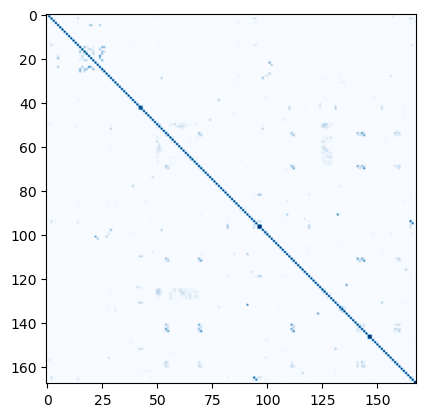

In [16]:
distance_mtx = squareform(pdist(predata, 'cosine'))
similarity_mtx = 1 - distance_mtx

plt.imshow(similarity_mtx, cmap= 'Blues')

Make prediction of the rating of user on item

In [17]:
user_to_predict = "NARINTIPP SHUSANG"
course_to_predict = "การวินิจฉัยภาวะฉุกเฉินที่ไม่ได้เกิดจากอุบัติเหตุ (Diagnostic Radiology of Non-Traumatic Emergency)"
idx_course_to_predict = 0
for i,x in enumerate(predata.index):
    if x == course_to_predict:
        idx_course_to_predict = i

selected_user_ratings = predata.loc[:, [user_to_predict]].squeeze()
selected_course_similarity = similarity_mtx[idx_course_to_predict]

numerator = np.dot(selected_user_ratings,selected_course_similarity)
denom = selected_course_similarity[selected_user_ratings > 0].sum()
if denom != 0:
    prediction = numerator / denom
else:
    prediction = 'Error: denom cannot be 0'
print(prediction)

0.700011555925721
